# Create benchmark class

In [3]:
from transformers import pipeline 
import numpy as np
import torch
import pandas as pd 
import matplotlib.pyplot as plt
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pipe = pipeline('text-classification', model=bert_ckpt, device=device) 
print("device : ",device)
print("device of pipeline : ", pipe.model.device)


device :  cuda:0
device of pipeline :  cuda:0


## Define the pipe

In [4]:
query = """hey, I want to buy a macbook pro"""
pipe(query)

[{'label': 'order', 'score': 0.24241438508033752}]

## load the datasets

In [5]:
from datasets import load_metric
from datasets import load_dataset
clinc = load_dataset("clinc_oos", "plus")
accuracy_score = load_metric("accuracy") 
intents = clinc["train"].features["intent"]
# intents.int2str([61])
print(intents.str2int('order'))

/tmp/ipykernel_2544896/4277778850.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


16


In [6]:
# iterate over the test set and make predictions
y_true = []
y_pred = []
for example in clinc["test"]:
    y_true.append(example["intent"])
    y_pred.append(pipe(example["text"])[0]["label"])
    print(example["text"])
    print(pipe(example["text"]))
    print(pipe(example["text"])[0]["label"])
    break

how would you say fly in italian
[{'label': 'translate', 'score': 0.5855258703231812}]
translate


In [7]:
sample = clinc["train"][0]
sample

{'text': 'what expression would i use to say i love you if i were an italian',
 'intent': 61}

## Load the time module

In [8]:
from time import perf_counter 
for _ in range(10): 
    start_time = perf_counter()   
    _ = pipe(query)
    latency = perf_counter() - start_time 
    print(f"latency (ms) - {latency * 1000}.3f")  
    

latency (ms) - 3.0596519354730844.3f
latency (ms) - 2.6677559362724423.3f
latency (ms) - 2.5822779862210155.3f
latency (ms) - 2.574198064394295.3f
latency (ms) - 2.5470320833846927.3f
latency (ms) - 2.6306190993636847.3f
latency (ms) - 2.8208669973537326.3f
latency (ms) - 2.640682039782405.3f
latency (ms) - 2.5947500253096223.3f
latency (ms) - 2.540757996030152.3f


/home/nghiaph/GEC/GEC_env/lib/python3.8/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


## Benchmark model class

In [9]:
from pathlib import Path
class PerformanceBenchmark: 
    def __init__(self, pipeline , dataset , optim_type = "BERT baseline"):
        self.pipeline = pipeline 
        self.dataset = dataset 
        self.optim_type = optim_type
    def compute_accuracy(self):
        """This overrides the PerformanceBenchmark.compute_accuracy() method"""
        # use gpu 
        preds, labels = [], []
        for example in self.dataset:
            input = example["text"]
            pred = self.pipeline(input)[0]["label"]
            pred = self.pipeline(example["text"])[0]["label"]
            preds.append(intents.str2int(pred))
            labels.append(example["intent"])
        accuracy = accuracy_score.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy
    def compute_size(self): 
        state_dict = self.pipeline.model.state_dict() # map each learnable layers to learnable parameteres (ex weights, bias)
        tmp_path = 'model.pt'
        torch.save(state_dict, tmp_path)
        # calculate size im MB 
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024) # use st_size to get the size of the file in bytes
        print(f"Model size (MB) - {size_mb:.2f}")  
        return {"size_mb": size_mb}
    def time_pipeline(self):
        """This overrides the PerformanceBenchmark.time_pipeline() method""" 
        latencies = [] 
        for _ in range(10):
            _ = self.pipeline(query)
        # time run 
        for _ in range(100):
            start_time = perf_counter() 
            _ = self.pipeline(query)
            latency = perf_counter() - start_time 
            latencies.append(latency)
        # compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies) 
        print(f"Average latency ms - {latency:.3f} +/- {time_std_ms:.3f}") 
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}
    def run_benchmark(self): 
        metrics = {} 
        metrics[self.optim_type] = self.compute_size() 
        metrics[self.optim_type].update(self.time_pipeline())  # update dictionary will add new k-v pair to the dictionary
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [10]:
# test compute accuracy
benchmark = PerformanceBenchmark(pipe, clinc["test"])
# benchmark.compute_accuracy()
# test time pipeline
perf_metrics = benchmark.run_benchmark()



Model size (MB) - 418.15
Average latency ms - 0.002 +/- 0.052
Accuracy on test set - 0.867


## Test the size of the model

In [11]:
list(pipe.model.state_dict().items())[42]


('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

In [12]:
torch.save(pipe.model.state_dict(), "model.pt")

# Knowledge Distillation

In [13]:
from transformers import TrainingArguments 
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature = 2.0, **kwargs): 
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

## DistillationTrainer

In [14]:
import torch.nn as nn
import torch.nn.functional as F 
from transformers import Trainer
class DistillationTrainer(Trainer):
    def __init__(self,*arg, teacher_model = None, **kwargs):
        super().__init__(*arg, **kwargs)
        self.teacher_model = teacher_model 
    def compute_loss(self, model, inputs, return_outputs=False):
        # extract loss from stuent 
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits
        student_loss = student_outputs.loss
        # extract loss from teacher
        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits
        klloss = nn.KLDivLoss(reduction="batchmean", log_target=False)
        loss_kd = klloss(
            F.log_softmax(student_logits / self.args.temperature, dim=-1),
            F.softmax(teacher_logits / self.args.temperature, dim=-1),
        ) * (self.args.temperature ** 2) # scale the loss by temperature
        # return weight student loss and kd loss
        loss = (1 - self.args.alpha) * student_loss + self.args.alpha * loss_kd
        return (loss, student_outputs) if return_outputs else loss
        


## Choose a good student intialization


In [15]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)
def tokenizer_text(batch):
    return student_tokenizer(batch["text"],truncation=True)
clinc_enc = clinc.map(tokenizer_text, batched=True)
clinc_enc = clinc_enc.rename_column("intent", "labels")

In [16]:
# login to hugging face to push model 
from huggingface_hub import login
# load token from file  .env 
import os
from dotenv import load_dotenv
load_dotenv()
token = os.getenv("HF_AUTH_TOKEN")
login(token = token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/nghiaph/.cache/huggingface/token
Login successful


In [17]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

## train model with alpha = 1 (no knowleadge from teacher)

In [18]:
# pipe.model.config

### set up training student args

In [19]:
BATCH_SIZE  = 1024

finetune_ckpt = "distilbert-base-uncased-fineturned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetune_ckpt,
    evaluation_strategy = "epoch",
    num_train_epochs = 10,
    learning_rate = 4e-4,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    alpha = 1 , 
    weight_decay = 0.01, 
    push_to_hub = True,
    logging_steps = 10
)
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

### create custom model configuration

In [20]:
from transformers import AutoConfig
num_labels = intents.num_classes
student_config = AutoConfig.from_pretrained(student_ckpt, 
                                            num_labels=num_labels, 
                                            id2label=id2label, 
                                            label2id=label2id)
# student_config

In [21]:
from transformers import AutoModelForSequenceClassification 
def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config = student_config).to(device))

In [22]:
# load teacher model
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification.from_pretrained(teacher_ckpt,
                                                                    num_labels = num_labels).to(device))

distilbert_trainer = DistillationTrainer(
    model_init = student_init,
    teacher_model = teacher_model,
    args = student_training_args,
    train_dataset = clinc_enc["train"],
    eval_dataset = clinc_enc["validation"],
    compute_metrics = compute_metrics,
    tokenizer = student_tokenizer,
)
distilbert_trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.023300,0.494924,0.541290
2,0.271300,0.133794,0.847097
3,0.128400,0.060719,0.916452
4,0.059100,0.040696,0.930968
5,0.048700,0.034644,0.935806
6,0.039700,0.030850,0.937742
7,0.037200,0.028688,0.939032
8,0.034500,0.027486,0.940645
9,0.033300,0.026708,0.939355
10,0.032400,0.026554,0.940000


TrainOutput(global_step=150, training_loss=0.16531579911708832, metrics={'train_runtime': 127.7009, 'train_samples_per_second': 1194.197, 'train_steps_per_second': 1.175, 'total_flos': 1083899623176720.0, 'train_loss': 0.16531579911708832, 'epoch': 10.0})

In [23]:
distilbert_trainer.push_to_hub("training completed!")

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

'https://huggingface.co/phnghiapro/distilbert-base-uncased-fineturned-clinc/tree/main/'

In [42]:
finetune_ckpt = "phnghiapro/distilbert-base-uncased-fineturned-clinc"
pipe = pipeline('text-classification', model=finetune_ckpt, device=device)


In [43]:
optim_type = "DistilBERT"
distilbert_benchmark = PerformanceBenchmark(pipe, clinc["test"], optim_type)
perf_metrics.update(distilbert_benchmark.run_benchmark())


Model size (MB) - 255.88
Average latency ms - 0.001 +/- 0.045


/home/nghiaph/GEC/GEC_env/lib/python3.8/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Accuracy on test set - 0.856


## plot the results model with alpha =1

In [26]:
df = pd.DataFrame.from_dict(perf_metrics, orient='index')
df.head()

,size_mb,time_avg_ms,time_std_ms,accuracy
BERT baseline,418.149377,2.477468,0.051576,0.867273
DistilBERT,255.882840,1.511154,0.037524,0.856182


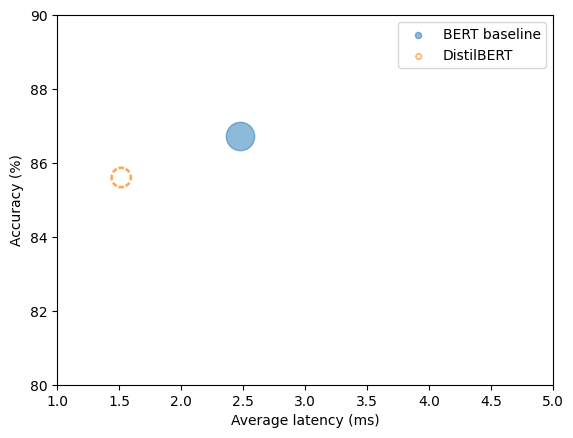

In [27]:


def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')
    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
            alpha=0.5, s=df_opt["size_mb"], label=idx,
            marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
            s=df_opt["size_mb"], label=idx, alpha=0.5)
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])
    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

## Finding Good Hyperparameters with Optuna


In [28]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2
import optuna
study = optuna.create_study()
# study.optimize(objective, n_trials=1000)

[I 2023-09-14 09:12:49,593] A new study created in memory with name: no-name-4753e682-90d8-4571-9e2f-df47caa4f2f4


In [30]:
# study.best_params


In [31]:
def hp_space(trial):
    return {
        # "num_train_epochs": trial.suggest_int("num_train_epochs", 9, 10),
    "alpha": trial.suggest_float("alpha", 0, 1),
    "temperature": trial.suggest_int("temperature", 2, 20)}

## Grid Search parameters

In [ ]:
# best_run = distilbert_trainer.hyperparameter_search(
#  n_trials=1, direction="maximize", hp_space=hp_space)
# print(best_run)


In [ ]:
# print(best_run)
#BestRun(run_id='0', objective=0.9467741935483871, hyperparameters={'alpha': 0.685702970499929, 'temperature': 3}, run_summary=None)

BestRun(run_id='0', objective=0.9467741935483871, hyperparameters={'alpha': 0.685702970499929, 'temperature': 3}, run_summary=None)


In [ ]:
# for k,v in best_run.hyperparameters.items():
#     setattr(student_training_args, k, v)
    
# # Define a new repository to store our distilled model
# distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
# student_training_args.output_dir = distilled_ckpt

# # Create a new Trainer with optimal parameters
# distil_trainer = DistillationTrainer(
#     model_init=student_init,
#     teacher_model=teacher_model, 
#     args=student_training_args,
#     train_dataset=clinc_enc['train'], 
#     eval_dataset=clinc_enc['validation'],
#     compute_metrics=compute_metrics, 
#     tokenizer=student_tokenizer
#     )
# distil_trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.

Epoch,Training Loss,Validation Loss,Accuracy
1,1.995600,1.175653,0.698710
2,0.636000,0.409309,0.903226
3,0.330100,0.247570,0.938387
4,0.183300,0.211699,0.946452
5,0.162800,0.199179,0.946774
6,0.145800,0.191002,0.948387
7,0.140200,0.185803,0.948065
8,0.136200,0.184995,0.947742
9,0.134400,0.183809,0.948387
10,0.133600,0.183695,0.948710


TrainOutput(global_step=150, training_loss=0.39425155719121296, metrics={'train_runtime': 130.0467, 'train_samples_per_second': 1172.655, 'train_steps_per_second': 1.153, 'total_flos': 1083899623176720.0, 'train_loss': 0.39425155719121296, 'epoch': 10.0})

In [35]:
distil_trainer.push_to_hub("Training complete")


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.16k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

'https://huggingface.co/phnghiapro/distilbert-base-uncased-distilled-clinc/tree/main/'

## Benchmark Distilllerd model

Model size (MB) - 255.88
Average latency ms - 0.002 +/- 0.108


/home/nghiaph/GEC/GEC_env/lib/python3.8/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Accuracy on test set - 0.877


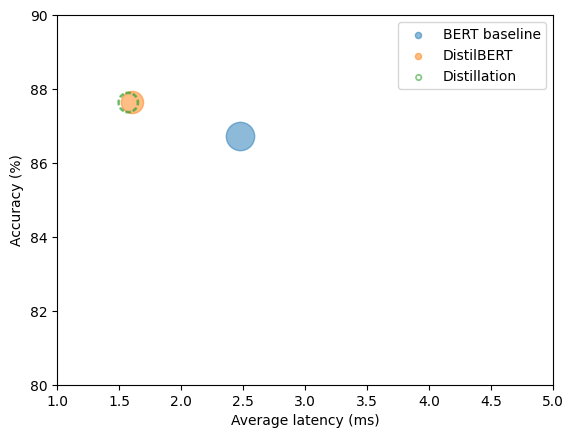

In [38]:
distilled_ckpt = "phnghiapro/distilbert-base-uncased-distilled-clinc"
pipe = pipeline('text-classification', model=distilled_ckpt, device=device)
optim_type = "Distillation"
distilbert_benchmark = PerformanceBenchmark(pipe, clinc["test"], optim_type)
perf_metrics.update(distilbert_benchmark.run_benchmark())

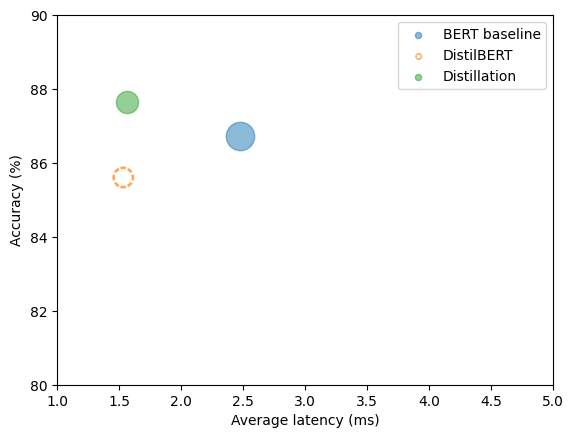

In [44]:
plot_metrics(perf_metrics, optim_type)
